## Field Rotation Animation

When doing astrophotography with an alt-azimuth mount, objects will rotate as they move across the sky. They will rotate at different rates depending on where the object is in the sky, and the latitude of the observer.

This tool uses much of the same code as the field rotation calculator notebook, but creates an animation of the field rotation effect as the observer moves from the equator to the north pole.

The equations for calculating the field rotation are taken from here: [RASC Calgary Centre - Field Rotation with an Alt-Az Telescope Mount](https://calgary.rasc.ca/field_rotation.htm):

> K = Observer's Constant = Angular Rate of Rotation of the Earth (degrees/hour) × cos(Observer's latitude) <br>
> = 15.04106858 degrees/hour × cos(Observer's latitude) <br>
> (15.04106858 degrees/hour = 360° / hours in a Sidereal day) <br>
> <br>
> Then field rotation for an object currently at azimuth $\text{Az}_{object}$ and altitude $\text{Alt}_{object}$ is given by: <br>
> <br>
> $\text{Field rotation (deg/hr)} = K  \frac {cos(\text{Az}_{object})} {cos(\text{Alt}_{object})}$
> <br>
> <br>


### Initialisation
Here we specify any libraries we need and any default paramters.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from astropy.time import Time,TimeDelta
from astropy.coordinates import EarthLocation, AltAz, SkyCoord
import astropy.units as u
from astropy.table import Table
from astroquery.simbad import Simbad
from timezonefinder import TimezoneFinder
import pytz
import datetime

plt.rcParams['figure.figsize'] = [10, 7]

### Functions
This section contains function modules for doing the calculations and plots

#### Get field rotation
This function gives a figure for field rotation in degrees per hour, using a given altitude, azimuth and observers latitude.

In [3]:
def calculate_field_rotation_deg_per_hour(azimuth, altitude, latitude):
    """
    Calculate the field rotation in degrees per hour.

    Parameters:
    - azimuth (float): Azimuth of the object in degrees, measured from North towards East.
    - altitude (float): Altitude of the object in degrees, above the horizon.
    - latitude (float): Latitude of the observer in degrees.

    Returns:
    - float: Field rotation in degrees per hour.
    """
    # Convert angles from degrees to radians for calculation
    az = np.radians(azimuth)
    alt = np.radians(altitude)
    Lat = np.radians(latitude)
    R_earth_rad = np.radians(15.04106858)

    # Observers constant
    K = R_earth_rad * np.cos(Lat)

    # Calculate the field rotation angle per hour
    phi_rad = K * np.cos(az) / np.cos(alt)

    # Convert the result back to degrees
    phi_deg = np.degrees(phi_rad)

    return phi_deg

#### Plot a field rotation grid without object
This function plots the field rotation for a given latitude, given as input an astropy earthlocation, without adding any object

In [4]:
def plot_field_rotation_alone(earth_location):
    # Generate a grid of azimuth and altitude values
    azimuth_grid, altitude_grid = np.meshgrid(np.linspace(0, 360, 520), np.linspace(0, 90, 180))

    latitude = earth_location.lat.degree

    # Calculate field rotation across the grid
    field_rotation_grid = calculate_field_rotation_deg_per_hour(azimuth_grid, altitude_grid, latitude)
    field_rotation_grid_clipped = np.abs((np.clip(field_rotation_grid,-60,60)))
    # Plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    colors_rgb = np.array([
        [0, 128, 0],
        [102, 204, 0],
        [255, 255, 0],
        [255, 191, 0],
        [255, 128, 0],
        [255, 0, 0]
    ]) / 255.0

    c = ax.contourf(np.radians(azimuth_grid), 90-altitude_grid, field_rotation_grid_clipped, levels=[0,2,5,10,20,80], colors=colors_rgb,alpha=0.3)

    # Add a color bar to indicate levels of field rotation
    plt.colorbar(c, ax=ax, orientation='vertical', label='Field Rotation in deg/hour')

    # Label the contour lines
    #ax.clabel(c, inline=True, fontsize=5)

    # Set labels for cardinal directions
    ax.set_xticks(np.radians([0, 45, 90, 135, 180, 225, 270, 315]))
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

    # Altitude rings to display
    altitude_rings = [15, 30, 45, 60, 75]

    # Convert altitude degrees to zenith distance for plotting
    # The plot's radius corresponds to zenith distance: 0 at the zenith and 90 at the horizon
    zenith_distances = [90 - altitude for altitude in altitude_rings]

    # Set the y-ticks to represent these zenith distances
    ax.set_yticks(zenith_distances)

    # Optionally, if you want to label the rings with their corresponding altitudes, you can do so:
    ax.set_yticklabels([f'{altitude}°' for altitude in altitude_rings], fontsize=10)

    # Plot formatting
    ax.set_theta_zero_location('N')
    #ax.set_theta_direction(-1)
    ax.set_ylim(0, 90)

    plt.show()

    return

#### Create the animation
This is the function that creates the animation

In [35]:
def plot_field_rotation_animation():
    # Generate a grid of azimuth and altitude values
    azimuth_grid, altitude_grid = np.meshgrid(np.linspace(0, 360, 520), np.linspace(0, 90, 180))

    # Plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    colors_rgb = np.array([
        [0, 128, 0],
        [102, 204, 0],
        [255, 255, 0],
        [255, 191, 0],
        [255, 128, 0],
        [255, 0, 0]
    ]) / 255.0

    field_rotation_grid = calculate_field_rotation_deg_per_hour(azimuth_grid, altitude_grid, 0)
    field_rotation_grid_clipped = np.abs(np.clip(field_rotation_grid, -60, 60))
    
    # Re-plot
    cset = ax.contourf(np.radians(azimuth_grid), 90-altitude_grid, field_rotation_grid_clipped, levels=[0, 2, 5, 10, 20, 80], colors=colors_rgb, alpha=0.3)
    ax.set_title(f"Latitude: 0°")

    # Add a color bar to indicate levels of field rotation
    plt.colorbar(cset, ax=ax, orientation='vertical', label='Field Rotation in deg/hour')

    # Set labels for cardinal directions
    ax.set_xticks(np.radians([0, 45, 90, 135, 180, 225, 270, 315]))
    ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

    # Altitude rings to display
    altitude_rings = [15, 30, 45, 60, 75]

    # Convert altitude degrees to zenith distance for plotting
    # The plot's radius corresponds to zenith distance: 0 at the zenith and 90 at the horizon
    zenith_distances = [90 - altitude for altitude in altitude_rings]

    # Set the y-ticks to represent these zenith distances
    ax.set_yticks(zenith_distances)

    # Optionally, if you want to label the rings with their corresponding altitudes, you can do so:
    ax.set_yticklabels([f'{altitude}°' for altitude in altitude_rings], fontsize=10)

    # Plot formatting
    ax.set_theta_zero_location('N')
    #ax.set_theta_direction(-1)
    ax.set_ylim(0, 90)
    
    def init():
        return cset,

    def update(latitude):
        ax.clear()  # Clear existing content
        field_rotation_grid = calculate_field_rotation_deg_per_hour(azimuth_grid, altitude_grid, latitude)
        field_rotation_grid_clipped = np.abs(np.clip(field_rotation_grid, -60, 60))
        
        # Re-plot
        ax.contourf(np.radians(azimuth_grid), 90-altitude_grid, field_rotation_grid_clipped, levels=[0, 2, 5, 10, 20, 80], colors=colors_rgb, alpha=0.3)
        ax.set_title(f"Latitude: {latitude}°")

        # Set labels for cardinal directions
        ax.set_xticks(np.radians([0, 45, 90, 135, 180, 225, 270, 315]))
        ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

        # Altitude rings to display
        altitude_rings = [15, 30, 45, 60, 75]

        # Convert altitude degrees to zenith distance for plotting
        # The plot's radius corresponds to zenith distance: 0 at the zenith and 90 at the horizon
        zenith_distances = [90 - altitude for altitude in altitude_rings]

        # Set the y-ticks to represent these zenith distances
        ax.set_yticks(zenith_distances)

        # Optionally, if you want to label the rings with their corresponding altitudes, you can do so:
        ax.set_yticklabels([f'{altitude}°' for altitude in altitude_rings], fontsize=10)

        # Plot formatting
        ax.set_theta_zero_location('N')
        #ax.set_theta_direction(-1)
        ax.set_ylim(0, 90)



    ani = FuncAnimation(fig, update, frames=np.linspace(0, 90, 365), init_func=init, blit=False)

    ani.save('field_rotation_latitude_variation.mp4', fps=8, extra_args=['-vcodec', 'libx264'], dpi=150)

    return

### Main code
This section is where we run the code itself and define our observer etc if needed.

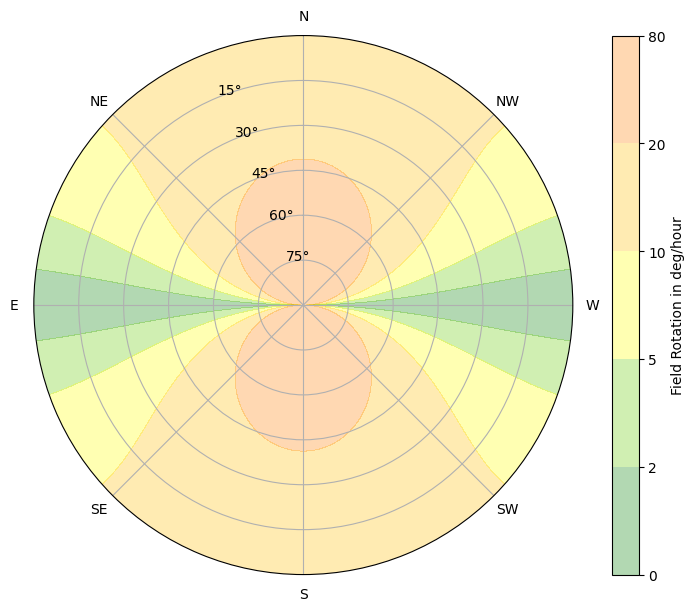

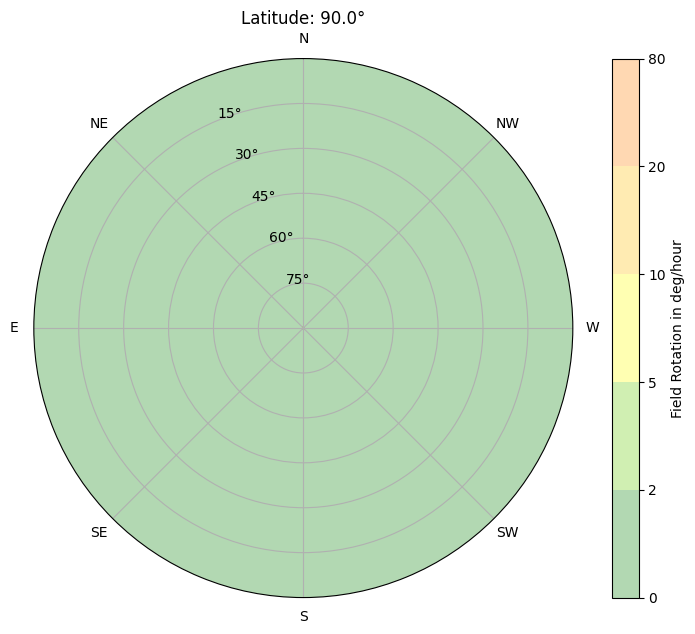

In [36]:
observer = EarthLocation(lat=0.0, lon=-120) # Latitude and longitude of observer

plot_field_rotation_alone(observer)

plot_field_rotation_animation()